# D-(+)-Glucose Dataset

Dataset was acquired from the BMRB ([bmse000797](https://bmrb.io/metabolomics/mol_summary/show_data.php?id=bmse000797&whichTab=2)).

## Defining Paths

In [1]:
from pathlib import Path
import nmrespy as ne

root = Path("../..")
data_path = root / "data" / "glucose" / "1"
output_dir = root / "code" / "reviewer-1" / "output"
            
output_dir.mkdir(exist_ok=True, parents=True)

## Pre-processing the Data

In [2]:
estimator_path = output_dir / "estimator_glucose.pkl"

if estimator_path.is_file():
    estimator = ne.Estimator2DJ.from_pickle(estimator_path)
else:
    estimator = ne.Estimator2DJ.new_bruker(data_path)
    estimator._data = ne.sig.exp_apodisation(estimator._data, 3.0, axes=[1])
    estimator.phase_data(0.073, -5.347)
    estimator.baseline_correction()
    estimator.to_pickle(estimator_path)

Saved file ../../code/reviewer-1/output/estimator_glucose.pkl.


## Visualising the 1D spectrum

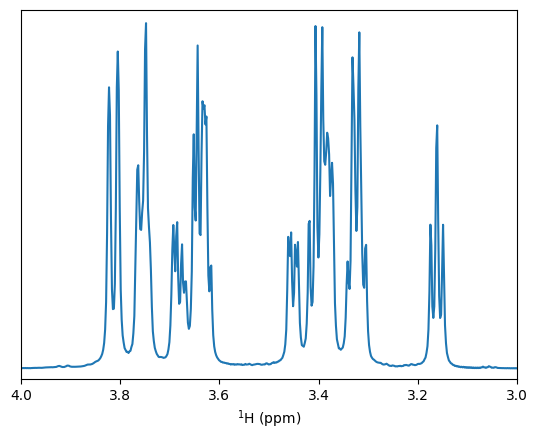

In [3]:
import matplotlib.pyplot as plt
spectrum = ne.sig.zf(estimator._data[0])
spectrum[0] *= 0.5
spectrum = ne.sig.ft(spectrum).real
_, shifts = estimator.get_shifts(unit="ppm", meshgrid=False, pts=(1, spectrum.size))

fig, ax = plt.subplots()
ax.plot(shifts, spectrum)
ax.set_xlim(4.0, 3.0)
ax.set_xlabel("$^{1}$H (ppm)")
ax.set_ylim(-1e4, 3.3e5)
ax.set_yticks([])
plt.show()

## Running the Estimation

In [12]:
import numpy as np
np.random.seed(0)

rerun = True 
try:
    if rerun:
        estimator._results = []
    estimator.get_results()
except ValueError:
    regions = [
        (3.9, 3.55),
        (3.55, 3.24),
        (3.24, 3.10),
    ]
    initial_guesses = [30, 25, 6]
    estimation_kwargs = dict(
        region_unit="ppm",
        noise_region=(6.6, 6.2),
        check_neg_amps_every=50,
        max_iterations=1500,
    )
    for region, initial_guess in zip(regions, initial_guesses):
        estimator.estimate(
            region=region,
            initial_guess=initial_guess,
            **estimation_kwargs,
        )
        estimator.to_pickle(estimator_path, force_overwrite=True)

┌──────────────────────────────────────┐
│ESTIMATING REGION: 3.9 - 3.55 ppm (F2)│
└──────────────────────────────────────┘
┌─────────────┐
│MMEMP STARTED│
└─────────────┘
--> Computing number of oscillators...
	Number of oscillators has been pre-defined
	Number of oscillators: 30
--> Pencil parameters: 16, 49
--> Enhanced Block Hankel matrix constructed:
	Size: 784 x 833
	Memory: 9.9651MiB
--> Performing Singular Value Decomposition...
--> Checking for oscillators with negative damping...
	None found
┌──────────────┐
│MMEMP COMPLETE│
└──────────────┘
Time elapsed: 0 mins, 7 secs, 953 msecs
┌────────────────────┐
│OPTIMISATION STARTED│
└────────────────────┘
┌───────────────────────────┐
│TRUST NCG ALGORITHM STARTED│
└───────────────────────────┘
┌───────┬──────────────┬──────────────┬──────────────┐
│ Iter. │  Objective   │  Grad. Norm  │ Trust Radius │
├───────┼──────────────┼──────────────┼──────────────┤
│ 0     │ 0.950453     │ 5.99906      │ 1            │
│ 10    │ 0.451051     │

## Plotting the Result

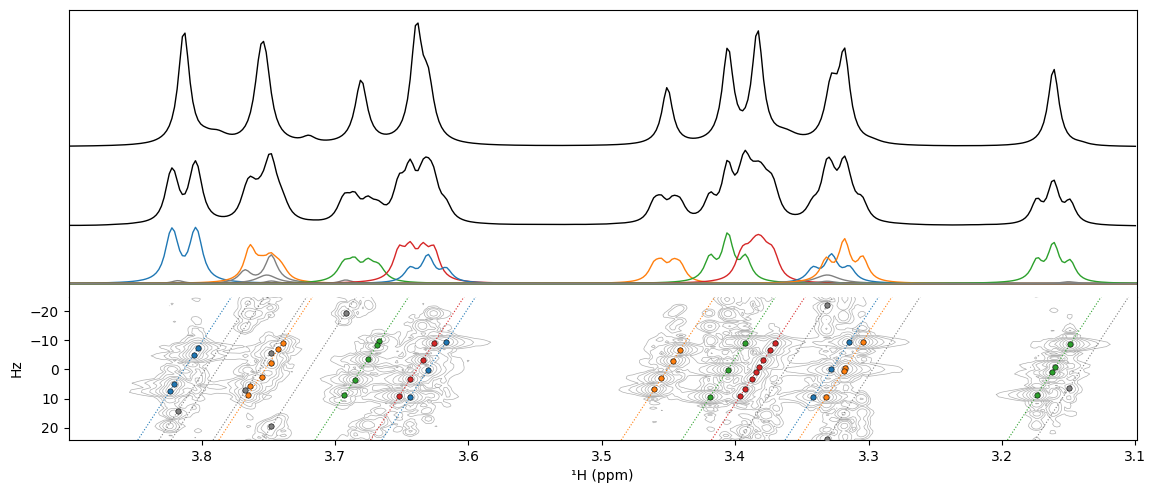

In [13]:
plot_kwargs = dict(
    region_unit="ppm",
    axes_bottom=0.1,
    contour_base=1.0e4,
    contour_factor=2.0,
    contour_nlevels=10,
    contour_color="#b0b0b0",
    marker_size=15.0,
    multiplet_show_center_freq=False,
    figsize=(12.0, 5.0),
    lb=4.0,
)

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"][:4]
colors.append("#808080")
mp_colors = [
    colors[i] for i in
    [0, -1, -1, -1, 1, -1, 2, 3, 0, 1, 2, 3, -1, 0, 1, -1, 2, -1]
]

estimator.plot_result(multiplet_colors=mp_colors, **plot_kwargs);

## Attempting to Remove Spurious Signals

In [14]:
estimator.predict_multiplets(rm_spurious=True);

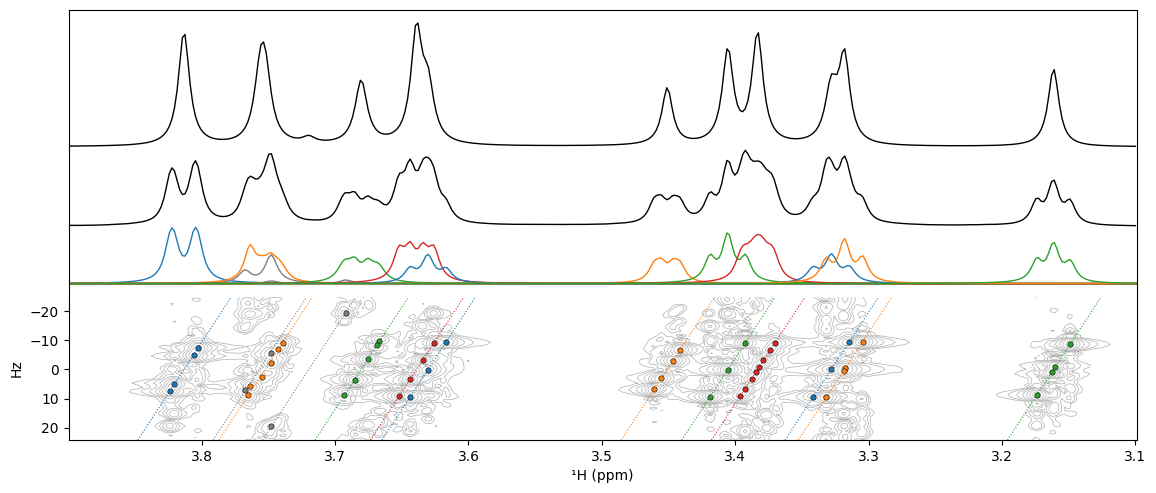

In [15]:
mp_colors = [
    colors[i] for i in
    [0, -1, 1, -1, 2, 3, 0, 1, 2, 3, 0, 1, 2]
]
fig, _ = estimator.plot_result(multiplet_colors=mp_colors, **plot_kwargs);
fig.savefig(output_dir / "glucose_result.png")